После scraping-а сайта, получили привычные по kaggle - csv-файл с данными (и директории с картинками).
Настала пора изучить пиццы.

Подключаем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

np.random.seed(42)

import cv2
import os
import sys

In [2]:
df = pd.read_csv('pizzas.csv', encoding='cp1251')
print(df.shape)

(20, 13)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
city_name         20 non-null object
city_url          20 non-null object
pizza_name        20 non-null object
pizza_eng_name    20 non-null object
pizza_url         20 non-null object
pizza_contain     20 non-null object
pizza_price       20 non-null int64
kiloCalories      20 non-null object
carbohydrates     20 non-null object
proteins          20 non-null object
fats              20 non-null object
size              20 non-null int64
weight            20 non-null object
dtypes: int64(2), object(11)
memory usage: 2.1+ KB


In [4]:
df.head()

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight
0,Калининград,/Kaliningrad,Двойная пепперони,double-pepperoni,https://dodopizza.ru/Kaliningrad/Product/doubl...,"Томатный соус, двойная порция пепперони и увел...",395,"257,52","26,04","10,77","12,11",25,470±50
1,Калининград,/Kaliningrad,Крэйзи пицца,crazy-pizza,https://dodopizza.ru/Kaliningrad/Product/crazy...,"Томатный соус, увеличенные порции цыпленка и п...",395,"232,37","31,33","9,08","7,64",25,410±50
2,Калининград,/Kaliningrad,Дон Бекон,pizza-don-bekon,https://dodopizza.ru/Kaliningrad/Product/pizza...,"Томатный соус, бекон, пепперони, цыпленок, кра...",395,274,"25,2","9,8","14,8",25,454±50
3,Калининград,/Kaliningrad,Грибы и ветчина,gribvetchina,https://dodopizza.ru/Kaliningrad/Product/gribv...,"Томатный соус, ветчина, шампиньоны, моцарелла",315,189,"23,9","9,3","6,1",25,370±50
4,Калининград,/Kaliningrad,Пицца-пирог,pizza-pirog,https://dodopizza.ru/Kaliningrad/Product/pizza...,"Сгущенное молоко, брусника, ананасы",315,"144,9","29,8","2,9","2,7",25,420±50


### Приведём данные к более удобному виду.

In [5]:
df['kiloCalories'] = df.kiloCalories.apply(lambda x: x.replace(',','.'))
df['carbohydrates'] = df.carbohydrates.apply(lambda x: x.replace(',','.'))
df['proteins'] = df.proteins.apply(lambda x: x.replace(',','.'))
df['fats'] = df.fats.apply(lambda x: x.replace(',','.'))
df['weight'], df['weight_err'] = df['weight'].str.split('±', 1).str

In [6]:
df['kiloCalories'] = df.kiloCalories.astype('float32')
df['carbohydrates'] = df.carbohydrates.astype('float32')
df['proteins'] = df.proteins.astype('float32')
df['fats'] = df.fats.astype('float32')
df['weight'] = df.weight.astype('int64')
df['weight_err'] = df.weight_err.astype('int64')

In [7]:
df.head()

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err
0,Калининград,/Kaliningrad,Двойная пепперони,double-pepperoni,https://dodopizza.ru/Kaliningrad/Product/doubl...,"Томатный соус, двойная порция пепперони и увел...",395,257.519989,26.040001,10.77,12.11,25,470,50
1,Калининград,/Kaliningrad,Крэйзи пицца,crazy-pizza,https://dodopizza.ru/Kaliningrad/Product/crazy...,"Томатный соус, увеличенные порции цыпленка и п...",395,232.369995,31.330000,9.08,7.64,25,410,50
2,Калининград,/Kaliningrad,Дон Бекон,pizza-don-bekon,https://dodopizza.ru/Kaliningrad/Product/pizza...,"Томатный соус, бекон, пепперони, цыпленок, кра...",395,274.000000,25.200001,9.80,14.80,25,454,50
3,Калининград,/Kaliningrad,Грибы и ветчина,gribvetchina,https://dodopizza.ru/Kaliningrad/Product/gribv...,"Томатный соус, ветчина, шампиньоны, моцарелла",315,189.000000,23.900000,9.30,6.10,25,370,50
4,Калининград,/Kaliningrad,Пицца-пирог,pizza-pirog,https://dodopizza.ru/Kaliningrad/Product/pizza...,"Сгущенное молоко, брусника, ананасы",315,144.899994,29.799999,2.90,2.70,25,420,50


Учитывая, что пищевая ценность продукта приводится в расчёте на 100 грамм, то для лучшего понимания - домножим их на массу пиццы.

In [8]:
df['pizza_kiloCalories'] = df.kiloCalories * df.weight / 100
df['pizza_carbohydrates'] = df.carbohydrates * df.weight / 100
df['pizza_proteins'] = df.proteins * df.weight / 100
df['pizza_fats'] = df.fats * df.weight / 100

In [9]:
df.describe()

,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
count,20.00000,20.000000,20.000000,20.000000,20.00000,20.0,20.000000,20.0,20.000000,20.000000,20.000000,20.000000
mean,370.50000,212.134491,25.443501,8.692500,8.44250,25.0,457.700000,50.0,969.942043,115.867950,39.857950,38.736650
std,33.16228,34.959122,2.204143,1.976283,3.20358,0.0,43.727746,0.0,175.835991,8.295421,9.989803,15.206275
min,315.00000,144.899994,22.100000,2.900000,2.70000,25.0,370.000000,50.0,608.579974,88.429999,12.180000,11.340000
25%,367.50000,188.250000,23.975000,7.975000,6.05000,25.0,420.000000,50.0,858.525000,113.010003,35.625000,28.159999
50%,385.00000,212.500000,24.950000,9.090000,8.20000,25.0,460.000000,50.0,966.358490,114.779002,39.580000,35.930001
75%,395.00000,235.527496,26.280001,9.800000,9.77500,25.0,485.000000,50.0,1095.459991,120.597001,45.707500,47.020001
max,395.00000,274.000000,31.330000,12.200000,14.80000,25.0,560.000000,50.0,1243.960000,128.453000,60.999999,68.080001


### Настала пора узнать, какие же пиццы самые-самые...
Итак, самая калорийная пицца

In [10]:
df[df.pizza_kiloCalories == np.max(df.pizza_kiloCalories)]

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
2,Калининград,/Kaliningrad,Дон Бекон,pizza-don-bekon,https://dodopizza.ru/Kaliningrad/Product/pizza...,"Томатный соус, бекон, пепперони, цыпленок, кра...",395,274.0,25.200001,9.8,14.8,25,454,50,1243.96,114.408003,44.492001,67.192001


Самая жирная пица:

In [11]:
df[df.pizza_fats == np.max(df.pizza_fats)]

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
14,Калининград,/Kaliningrad,Мясная,myasnaya-pizza,https://dodopizza.ru/Kaliningrad/Product/myasn...,"Томатный соус, охотничьи колбаски, бекон, ветч...",395,268.0,24.200001,9.1,14.8,25,460,50,1232.8,111.320004,41.860002,68.080001


Самая богатая углеводами:

In [12]:
df[df.pizza_carbohydrates == np.max(df.pizza_carbohydrates)]

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
1,Калининград,/Kaliningrad,Крэйзи пицца,crazy-pizza,https://dodopizza.ru/Kaliningrad/Product/crazy...,"Томатный соус, увеличенные порции цыпленка и п...",395,232.369995,31.33,9.08,7.64,25,410,50,952.71698,128.453,37.228,31.323999


Самая богатая белками:

In [13]:
df[df.pizza_proteins == np.max(df.pizza_proteins)]

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
7,Калининград,/Kaliningrad,Гавайская,gavayskaya-pizza,https://dodopizza.ru/Kaliningrad/Product/gavay...,"Томатный соус, ананасы, цыпленок, моцарелла",315,216.0,25.0,12.2,7.4,25,500,50,1080.0,125.0,60.999999,37.0


Самая тяжёлая по весу пицца:

In [14]:
df[df.weight == np.max(df.weight)]

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
8,Калининград,/Kaliningrad,Додо,pizza-dodo,https://dodopizza.ru/Kaliningrad/Product/pizza...,"Томатный соус, говядина (фарш), ветчина, пеппе...",395,203.899994,22.1,8.6,8.9,25,560,50,1141.839966,123.760002,48.160002,49.839998


Самая лёгкая по весу пицца:

In [15]:
df[df.weight == np.min(df.weight)]

,city_name,city_url,pizza_name,pizza_eng_name,pizza_url,pizza_contain,pizza_price,kiloCalories,carbohydrates,proteins,fats,size,weight,weight_err,pizza_kiloCalories,pizza_carbohydrates,pizza_proteins,pizza_fats
3,Калининград,/Kaliningrad,Грибы и ветчина,gribvetchina,https://dodopizza.ru/Kaliningrad/Product/gribv...,"Томатный соус, ветчина, шампиньоны, моцарелла",315,189.0,23.9,9.3,6.1,25,370,50,699.3,88.429999,34.410001,22.57


### Получаем названия пицц

In [16]:
pizza_names = df['pizza_name'].tolist()
pizza_eng_names = df['pizza_eng_name'].tolist()
print( pizza_eng_names )

['double-pepperoni', 'crazy-pizza', 'pizza-don-bekon', 'gribvetchina', 'pizza-pirog', 'pizza-margarita', 'syrnaya-pizza', 'gavayskaya-pizza', 'pizza-dodo', 'pizza-chetyre-sezona', 'ovoshi-i-griby', 'italyanskaya-pizza', 'meksikanskaya-pizza', 'morskaya-pizza', 'myasnaya-pizza', 'pizza-pepperoni', 'ranch-pizza', 'pizza-syrnyi-cyplenok', 'pizza-cyplenok-barbekyu', 'chizburger-pizza']


### Получаем путь до картинок - нас интересует 3-я картинка (вид сверху)

In [17]:
image_paths = []
for name in pizza_eng_names:
    path = os.path.join(name, name+'3.jpg')
    image_paths.append(path)
print(image_paths)

['double-pepperoni\\double-pepperoni3.jpg', 'crazy-pizza\\crazy-pizza3.jpg', 'pizza-don-bekon\\pizza-don-bekon3.jpg', 'gribvetchina\\gribvetchina3.jpg', 'pizza-pirog\\pizza-pirog3.jpg', 'pizza-margarita\\pizza-margarita3.jpg', 'syrnaya-pizza\\syrnaya-pizza3.jpg', 'gavayskaya-pizza\\gavayskaya-pizza3.jpg', 'pizza-dodo\\pizza-dodo3.jpg', 'pizza-chetyre-sezona\\pizza-chetyre-sezona3.jpg', 'ovoshi-i-griby\\ovoshi-i-griby3.jpg', 'italyanskaya-pizza\\italyanskaya-pizza3.jpg', 'meksikanskaya-pizza\\meksikanskaya-pizza3.jpg', 'morskaya-pizza\\morskaya-pizza3.jpg', 'myasnaya-pizza\\myasnaya-pizza3.jpg', 'pizza-pepperoni\\pizza-pepperoni3.jpg', 'ranch-pizza\\ranch-pizza3.jpg', 'pizza-syrnyi-cyplenok\\pizza-syrnyi-cyplenok3.jpg', 'pizza-cyplenok-barbekyu\\pizza-cyplenok-barbekyu3.jpg', 'chizburger-pizza\\chizburger-pizza3.jpg']


### Загружаем картинки

In [18]:
images = []
for path in image_paths:
    print('Load image:', path)
    image = cv2.imread(path)
    if image is not None:
        images.append(image)
    else:
        print('Error read image:', path)

Load image: double-pepperoni\double-pepperoni3.jpg
Load image: crazy-pizza\crazy-pizza3.jpg
Load image: pizza-don-bekon\pizza-don-bekon3.jpg
Load image: gribvetchina\gribvetchina3.jpg
Load image: pizza-pirog\pizza-pirog3.jpg
Load image: pizza-margarita\pizza-margarita3.jpg
Load image: syrnaya-pizza\syrnaya-pizza3.jpg
Load image: gavayskaya-pizza\gavayskaya-pizza3.jpg
Load image: pizza-dodo\pizza-dodo3.jpg
Load image: pizza-chetyre-sezona\pizza-chetyre-sezona3.jpg
Load image: ovoshi-i-griby\ovoshi-i-griby3.jpg
Load image: italyanskaya-pizza\italyanskaya-pizza3.jpg
Load image: meksikanskaya-pizza\meksikanskaya-pizza3.jpg
Load image: morskaya-pizza\morskaya-pizza3.jpg
Load image: myasnaya-pizza\myasnaya-pizza3.jpg
Load image: pizza-pepperoni\pizza-pepperoni3.jpg
Load image: ranch-pizza\ranch-pizza3.jpg
Load image: pizza-syrnyi-cyplenok\pizza-syrnyi-cyplenok3.jpg
Load image: pizza-cyplenok-barbekyu\pizza-cyplenok-barbekyu3.jpg
Load image: chizburger-pizza\chizburger-pizza3.jpg


### Посмотрим на картинку

(380, 710, 3)


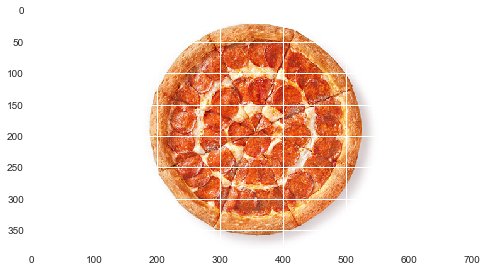

In [19]:
def plot_img(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

print(images[0].shape)
plot_img(images[0])

### Пиццы располагаются в одной и той же области - вырезаем

(380, 380, 3)
20


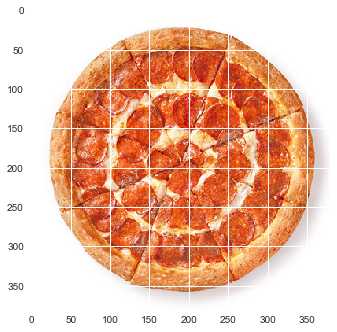

In [20]:
pizza_imgs = []
for img in images:
    y, x, height, width = 0, 165, 380, 380
    pizza_crop = img[y:y+height, x:x+width]
    pizza_imgs.append(pizza_crop)
print(pizza_imgs[0].shape)
print(len(pizza_imgs))
plot_img(pizza_imgs[0])

### Посмотрим все фотографии

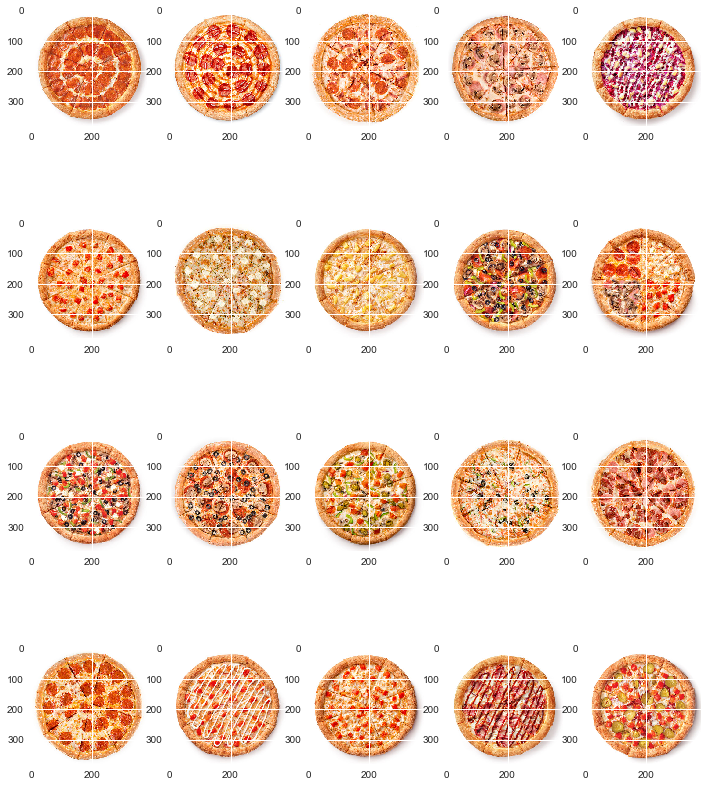

In [21]:
fig = plt.figure(figsize=(12,15))
for i in range(0, len(pizza_imgs)):
    fig.add_subplot(4,5,i+1)
    plot_img(pizza_imgs[i])


Пицца четыре сезона явно выбивается по своей структуре, так как, по сути, состоит из четырёх разных пицц.

### Изучим ингредиенты

In [22]:
def split_contain(contain):
    lst = contain.split(',')
    print(len(lst),':', lst)

for i, row in df.iterrows():
    split_contain(row.pizza_contain)

2 : ['Томатный соус', ' двойная порция пепперони и увеличенная порция моцареллы']
4 : ['Томатный соус', ' увеличенные порции цыпленка и пепперони', ' моцарелла', ' кисло-сладкий соус']
6 : ['Томатный соус', ' бекон', ' пепперони', ' цыпленок', ' красный лук', ' моцарелла']
4 : ['Томатный соус', ' ветчина', ' шампиньоны', ' моцарелла']
3 : ['Сгущенное молоко', ' брусника', ' ананасы']
4 : ['Томатный соус', ' томаты', ' увеличенная порция моцареллы', ' орегано']
4 : ['Томатный соус', ' брынза', ' увеличенная порция сыра моцарелла', ' орегано']
4 : ['Томатный соус', ' ананасы', ' цыпленок', ' моцарелла']
9 : ['Томатный соус', ' говядина (фарш)', ' ветчина', ' пепперони', ' красный лук', ' маслины', ' сладкий перец', ' шампиньоны', ' моцарелла']
8 : ['Томатный соус', ' пепперони', ' ветчина', ' брынза', ' томаты', ' шампиньоны', ' моцарелла', ' орегано']
9 : ['Томатный соус', ' брынза', ' маслины', ' сладкий перец', ' томаты', ' шампиньоны', ' красный лук', ' моцарелла', ' базилик']
6 : ['

Проблема, что в нескольких пиццах указываются модификаторы вида:
- "двойная порция"
- "увеличенная порция"

При этом, после модификаторов может идти перечисление ингредиетов через союз И.

Гипотезы:
- модификатор двойная порция можно заменить указав нужный ингредиент два раза.
- модификатор увеличенная порция пока можно опустить (так как на фотографиях разница не заметна)

Видим, что модификатор "увеличенная порция", относится только к сыру моцарелла. 
Так же один раз встречается:
"увеличенная порция сыра моцарелла"

Кстати, сразу же бросается в глаза, что основной используемый соус - томатный, а сыр - моцарелла.

### Почистим ингедиенты, чтобы привести к нормальному виду

In [23]:
def split_contain2(contain):
    lst = contain.split(',')
    #print(len(lst),':', lst)
    for i in range(len(lst)):
        item = lst[i]
        item = item.replace('увеличенная порция', '')
        item = item.replace('увеличенные порции', '')
        item = item.replace('сыра моцарелла', 'моцарелла')
        item = item.replace('моцареллы', 'моцарелла')
        item = item.replace('цыпленка', 'цыпленок')
        and_pl = item.find(' и ')
        if and_pl != -1:
            item1 = item[0:and_pl]
            item2 = item[and_pl+3:]
            item = item1
            lst.insert(i+1, item2.strip())
        double_pl = item.find('двойная порция ')
        if double_pl != -1:
            item = item[double_pl+15:]
            lst.insert(i+1, item.strip())
        lst[i] = item.strip()
    # last one
    for i in range(len(lst)):
        lst[i] = lst[i].strip()
    print(len(lst),':', lst)
    return lst

ingredients = []
ingredients_count = []
for i, row in df.iterrows():
    print(row.pizza_name)
    lst = split_contain2(row.pizza_contain)
    ingredients.append(lst)
    ingredients_count.append(len(lst))
ingredients_count

Двойная пепперони
4 : ['Томатный соус', 'пепперони', 'пепперони', 'моцарелла']
Крэйзи пицца 
5 : ['Томатный соус', 'цыпленок', 'пепперони', 'моцарелла', 'кисло-сладкий соус']
Дон Бекон
6 : ['Томатный соус', 'бекон', 'пепперони', 'цыпленок', 'красный лук', 'моцарелла']
Грибы и ветчина
4 : ['Томатный соус', 'ветчина', 'шампиньоны', 'моцарелла']
Пицца-пирог
3 : ['Сгущенное молоко', 'брусника', 'ананасы']
Маргарита
4 : ['Томатный соус', 'томаты', 'моцарелла', 'орегано']
Сырная
4 : ['Томатный соус', 'брынза', 'моцарелла', 'орегано']
Гавайская
4 : ['Томатный соус', 'ананасы', 'цыпленок', 'моцарелла']
Додо
9 : ['Томатный соус', 'говядина (фарш)', 'ветчина', 'пепперони', 'красный лук', 'маслины', 'сладкий перец', 'шампиньоны', 'моцарелла']
Четыре сезона
8 : ['Томатный соус', 'пепперони', 'ветчина', 'брынза', 'томаты', 'шампиньоны', 'моцарелла', 'орегано']
Овощи и грибы
9 : ['Томатный соус', 'брынза', 'маслины', 'сладкий перец', 'томаты', 'шампиньоны', 'красный лук', 'моцарелла', 'базилик']
Ита

[4, 5, 6, 4, 3, 4, 4, 4, 9, 8, 9, 6, 8, 6, 5, 3, 6, 4, 6, 7]

### Посмотрим минимальное и максимальное количество ингредиентов

In [24]:
min_count = np.min(ingredients_count)
print('min:', min_count)
max_count = np.max(ingredients_count)
print('max:', max_count)

min: 3
max: 9


In [25]:
print('min:', np.array(pizza_names)[ingredients_count == min_count] )
print('max:', np.array(pizza_names)[ingredients_count == max_count] )

min: ['Пицца-пирог' 'Пепперони']
max: ['Додо' 'Овощи и грибы']


Интересно, больше всего ингредиентов (9 штук) в пиццах: **Додо** и **Овощи и грибы**.

### Заполним табличку ингредиентов.

In [26]:
df_ingredients = pd.DataFrame(ingredients)
df_ingredients.fillna(value='0', inplace=True)
df_ingredients

,0,1,2,3,4,5,6,7,8
0,Томатный соус,пепперони,пепперони,моцарелла,0,0,0,0,0
1,Томатный соус,цыпленок,пепперони,моцарелла,кисло-сладкий соус,0,0,0,0
2,Томатный соус,бекон,пепперони,цыпленок,красный лук,моцарелла,0,0,0
3,Томатный соус,ветчина,шампиньоны,моцарелла,0,0,0,0,0
4,Сгущенное молоко,брусника,ананасы,0,0,0,0,0,0
5,Томатный соус,томаты,моцарелла,орегано,0,0,0,0,0
6,Томатный соус,брынза,моцарелла,орегано,0,0,0,0,0
7,Томатный соус,ананасы,цыпленок,моцарелла,0,0,0,0,0
8,Томатный соус,говядина (фарш),ветчина,пепперони,красный лук,маслины,сладкий перец,шампиньоны,моцарелла
9,Томатный соус,пепперони,ветчина,брынза,томаты,шампиньоны,моцарелла,орегано,0


In [27]:
df_ingredients.describe()

,0,1,2,3,4,5,6,7,8
count,20,20,20,20,20,20,20,20,20
unique,4,13,10,12,6,7,4,4,3
top,Томатный соус,пепперони,пепперони,моцарелла,0,0,0,0,0
freq,16,4,3,5,8,10,15,16,18


Как и ожидалось - самый используемый соус - томатный. Стандартный рецепт - состоит из 4 ингредиентов.

Забавно, что образовался **новый рецепт для пиццы**.

Посмотрим сколько раз встречается тот или иной ингредиент:

In [28]:
df_ingredients.stack().value_counts()

0                     69
моцарелла             19
Томатный соус         16
пепперони              8
томаты                 7
цыпленок               7
красный лук            7
шампиньоны             6
ветчина                5
сладкий перец          4
бекон                  4
орегано                4
маслины                4
брынза                 3
ананасы                2
Сырный соус            2
чеснок                 1
кисло-сладкий соус     1
базилик                1
соус Барбекю           1
креветки               1
халапеньо              1
Сгущенное молоко       1
соленые огурцы         1
говядина (фарш)        1
охотничьи колбаски     1
брусника               1
говядина               1
Соус Ранч              1
dtype: int64

Опять же: моцарелла, Томатный соус, пепперони.

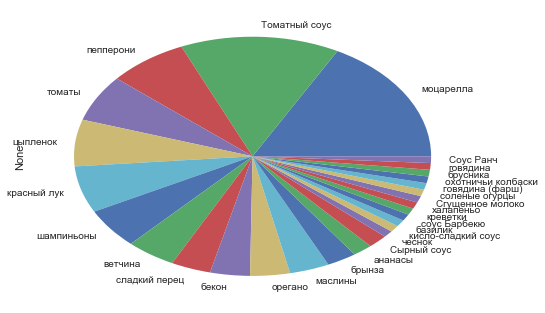

In [29]:
df_ingredients.stack().value_counts().drop('0').plot.pie()

### Теперь закодируем ингредиенты.

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

ingredients_full = df_ingredients.values.tolist()

# flatten lists
flat_ingredients = [item for sublist in ingredients_full for item in sublist]
print(flat_ingredients)
print(len(flat_ingredients))

np_ingredients = np.array(flat_ingredients)
#print(np_ingredients)

labelencoder = LabelEncoder()
ingredients_encoded = labelencoder.fit_transform(np_ingredients)
print(ingredients_encoded)

label_max = np.max(ingredients_encoded)
print('max:', label_max)

['Томатный соус', 'пепперони', 'пепперони', 'моцарелла', '0', '0', '0', '0', '0', 'Томатный соус', 'цыпленок', 'пепперони', 'моцарелла', 'кисло-сладкий соус', '0', '0', '0', '0', 'Томатный соус', 'бекон', 'пепперони', 'цыпленок', 'красный лук', 'моцарелла', '0', '0', '0', 'Томатный соус', 'ветчина', 'шампиньоны', 'моцарелла', '0', '0', '0', '0', '0', 'Сгущенное молоко', 'брусника', 'ананасы', '0', '0', '0', '0', '0', '0', 'Томатный соус', 'томаты', 'моцарелла', 'орегано', '0', '0', '0', '0', '0', 'Томатный соус', 'брынза', 'моцарелла', 'орегано', '0', '0', '0', '0', '0', 'Томатный соус', 'ананасы', 'цыпленок', 'моцарелла', '0', '0', '0', '0', '0', 'Томатный соус', 'говядина (фарш)', 'ветчина', 'пепперони', 'красный лук', 'маслины', 'сладкий перец', 'шампиньоны', 'моцарелла', 'Томатный соус', 'пепперони', 'ветчина', 'брынза', 'томаты', 'шампиньоны', 'моцарелла', 'орегано', '0', 'Томатный соус', 'брынза', 'маслины', 'сладкий перец', 'томаты', 'шампиньоны', 'красный лук', 'моцарелла', 'ба

Получается, что для приготовления, используется целых 27 ингредиентов.

In [31]:
for label in range(label_max):
    print(label, labelencoder.inverse_transform(label))

0 0
1 Сгущенное молоко
2 Соус Ранч
3 Сырный соус
4 Томатный соус
5 ананасы
6 базилик
7 бекон
8 брусника
9 брынза
10 ветчина
11 говядина
12 говядина (фарш)
13 кисло-сладкий соус
14 красный лук
15 креветки
16 маслины
17 моцарелла
18 орегано
19 охотничьи колбаски
20 пепперони
21 сладкий перец
22 соленые огурцы
23 соус Барбекю
24 томаты
25 халапеньо
26 цыпленок
27 чеснок


In [32]:
lb_ingredients = []
for lst in ingredients_full:
    lb_ingredients.append(labelencoder.transform(lst).tolist())
#lb_ingredients = np.array(lb_ingredients)
lb_ingredients

[[4, 20, 20, 17, 0, 0, 0, 0, 0],
 [4, 26, 20, 17, 13, 0, 0, 0, 0],
 [4, 7, 20, 26, 14, 17, 0, 0, 0],
 [4, 10, 28, 17, 0, 0, 0, 0, 0],
 [1, 8, 5, 0, 0, 0, 0, 0, 0],
 [4, 24, 17, 18, 0, 0, 0, 0, 0],
 [4, 9, 17, 18, 0, 0, 0, 0, 0],
 [4, 5, 26, 17, 0, 0, 0, 0, 0],
 [4, 12, 10, 20, 14, 16, 21, 28, 17],
 [4, 20, 10, 9, 24, 28, 17, 18, 0],
 [4, 9, 16, 21, 24, 28, 14, 17, 6],
 [4, 20, 16, 28, 17, 18, 0, 0, 0],
 [4, 25, 21, 26, 24, 28, 14, 17, 0],
 [4, 15, 16, 21, 14, 17, 0, 0, 0],
 [4, 19, 7, 10, 17, 0, 0, 0, 0],
 [4, 20, 17, 0, 0, 0, 0, 0, 0],
 [2, 26, 10, 24, 27, 17, 0, 0, 0],
 [3, 26, 24, 17, 0, 0, 0, 0, 0],
 [4, 26, 7, 14, 17, 23, 0, 0, 0],
 [3, 11, 7, 22, 24, 14, 17, 0, 0]]

In [33]:
onehotencoder = OneHotEncoder(sparse=False)
ingredients_onehotencoded = onehotencoder.fit_transform(ingredients_encoded.reshape(-1, 1))
print(ingredients_onehotencoded.shape)
ingredients_onehotencoded[0]

(180, 29)


array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [34]:
df_ingredients_encoded = pd.DataFrame(lb_ingredients)
df_ingredients_encoded

,0,1,2,3,4,5,6,7,8
0,4,20,20,17,0,0,0,0,0
1,4,26,20,17,13,0,0,0,0
2,4,7,20,26,14,17,0,0,0
3,4,10,28,17,0,0,0,0,0
4,1,8,5,0,0,0,0,0,0
5,4,24,17,18,0,0,0,0,0
6,4,9,17,18,0,0,0,0,0
7,4,5,26,17,0,0,0,0,0
8,4,12,10,20,14,16,21,28,17
9,4,20,10,9,24,28,17,18,0


In [35]:
df_ingredients_encoded.describe()

,0,1,2,3,4,5,6,7,8
count,20.000000,20.000000,20.000000,20.000000,20.00000,20.00000,20.000000,20.000000,20.000000
mean,3.650000,16.900000,15.700000,17.100000,11.45000,10.30000,4.150000,4.000000,1.150000
std,0.812728,7.411939,6.705065,7.608167,10.34904,11.24418,7.492277,8.479076,3.963983
min,1.000000,5.000000,5.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
25%,4.000000,9.750000,10.000000,16.250000,0.00000,0.00000,0.000000,0.000000,0.000000
50%,4.000000,19.500000,16.500000,17.500000,14.00000,7.00000,0.000000,0.000000,0.000000
75%,4.000000,24.250000,20.000000,21.250000,18.75000,17.25000,3.500000,0.000000,0.000000
max,4.000000,26.000000,28.000000,28.000000,27.00000,28.00000,21.000000,28.000000,17.000000


In [36]:
df_ingredients_encoded[0].value_counts()

4    16
3     2
2     1
1     1
Name: 0, dtype: int64